## **0.0** Set Up

In [97]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
from collections import Counter

## **1.0** EDA & Data Prep

### application_data.csv

In [98]:
df_application = pd.read_csv('application_data.csv')
df_application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Initial Data Cleaning

#### 1. Check Nulls and Duplicates - Overall

In [99]:
print("Number of rows:", df_application.shape[0])
print("Number of columns:", df_application.shape[1])
num_dups = df_application.duplicated().sum()
print("Number of duplicate rows:", num_dups)
num_nulls = df_application.isnull().any(axis=1).sum()
print("Number of rows with null values:", num_nulls)

Number of rows: 307511
Number of columns: 122
Number of duplicate rows: 0
Number of rows with null values: 298909


#### 2. Check target variable

In [100]:
import matplotlib.pyplot as plt

def plot_value_counts_with_percentages(data, column, figsize=(8, 5), colors=None, title=None):
    """
    Plots value counts of a specified column with percentages annotated.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column to analyze.
        figsize (tuple): Size of the plot (default: (8, 5)).
        colors (list): List of colors for the bars (default: None).
        title (str): Title of the plot (default: None).
    """
    # Get value counts and percentages
    value_counts = data[column].value_counts()
    percentages = value_counts / value_counts.sum() * 100

    # Plot the bar chart
    plt.figure(figsize=figsize)
    bars = plt.bar(value_counts.index, value_counts.values, color=colors)

    # Annotate bars with percentages
    for bar, percentage in zip(bars, percentages):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Center of the bar
            bar.get_height() + value_counts.max() * 0.01,  # Slightly above the bar
            f'{percentage:.1f}%',              # Format percentage to 1 decimal place
            ha='center', va='bottom', fontsize=10
        )

    # Add title and labels
    plt.title(title if title else f'Distribution of {column}', fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal
    plt.show()

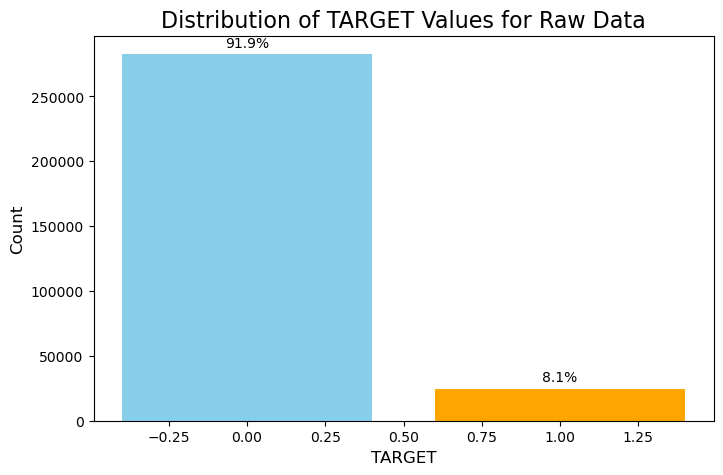

In [101]:
# check target distribution
plot_value_counts_with_percentages(
    data=df_application,
    column='TARGET',
    colors=['skyblue', 'orange'],
    title='Distribution of TARGET Values for Raw Data'
)

#### 3. Drop Columns with Missing rate >20%

In [102]:
#check missing percentage
na_percentage = (df_application.isna().sum() / len(df_application)) * 100
na_percentage_df = na_percentage.to_frame(name='NaN_Percentage').sort_values(by='NaN_Percentage', ascending=False)
na_percentage_df2 = na_percentage_df.loc[na_percentage_df['NaN_Percentage'] >20]
na_percentage_df2.shape

(50, 1)

In [103]:
df_application_clean = df_application.drop(na_percentage_df2.index, axis=1)
df_application_clean.shape

(307511, 72)

#### 4. Drop Rows with N/A value

In [104]:
df_application_clean= df_application_clean.dropna()
df_application_clean.shape

(244280, 72)

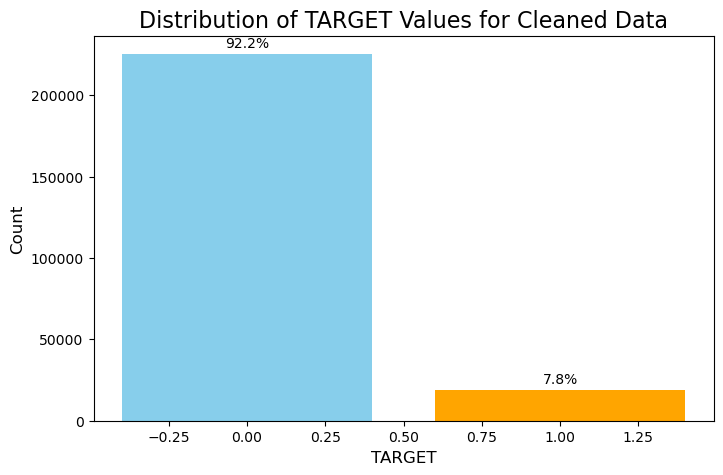

In [105]:
# check target distribution again
plot_value_counts_with_percentages(
    data=df_application_clean,
    column='TARGET',
    colors=['skyblue', 'orange'],
    title='Distribution of TARGET Values for Cleaned Data'
)

### Check & Process Data by Types

In [106]:
dtype_df = pd.DataFrame(df_application_clean.dtypes, columns=['DataType']).reset_index()
dtype_df.columns = ['ColumnName', 'DataType']
dtype_df['DataType'].value_counts()

int64      41
float64    20
object     11
Name: DataType, dtype: int64

### A. Flag (Boolean) Variables

In [107]:
flag_columns = [col for col in df_application_clean.columns if set(df_application_clean[col].unique()) <= {0, 1} or set(df_application_clean[col].unique()) <= {'Y', 'N'}]
flag_columns.remove('TARGET')
print(flag_columns)
# Convert identified flag columns to numeric 0 and 1
for col in flag_columns:
    df_application_clean[col] = df_application_clean[col].replace({'Y': 1, 'N': 0}).astype(int)


['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


In [108]:
df_application_clean.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0,1,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,100004,0,Revolving loans,M,1,1,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,0,1,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,1,1,1,1,1,0,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,Other,0.354225,0.621226,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,1,1,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,1,1,0,1,1,0,3.0,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,0.724000,0.492060,1.0,0.0,1.0,0.0,-1562.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,1,1,0,360000.0,1530000.0,42075.0,1530000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449,-4597.0,-2379,1,1,1,1,0,0,2.0,3,3,MONDAY,16,0,0,0,0,1,1,Other,0.714279,0.540654,2.0,0.0,2.0,0.0,-1070.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### B. Categorical Variables

In [109]:
non_numeric_df = df_application_clean.select_dtypes(exclude='number')

pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', None)     
pd.set_option('display.max_columns', None)  
    
unique_values_df = pd.DataFrame({col: [non_numeric_df[col].unique()] for col in non_numeric_df.columns}).transpose()
unique_values_df.columns = ['UniqueValues']
unique_values_df = unique_values_df.reset_index().rename(columns={'index': 'ColumnName'})
unique_values_df

,ColumnName,UniqueValues
0,NAME_CONTRACT_TYPE,"[Cash loans, Revolving loans]"
1,CODE_GENDER,"[M, F, XNA]"
2,NAME_TYPE_SUITE,"[Unaccompanied, Spouse, partner, Children, Family, Other_A, Other_B, Group of people]"
3,NAME_INCOME_TYPE,"[Working, State servant, Commercial associate, Pensioner, Unemployed, Student, Businessman]"
4,NAME_EDUCATION_TYPE,"[Secondary / secondary special, Higher education, Incomplete higher, Lower secondary, Academic degree]"
5,NAME_FAMILY_STATUS,"[Single / not married, Married, Widow, Civil marriage, Separated]"
6,NAME_HOUSING_TYPE,"[House / apartment, Rented apartment, Municipal apartment, With parents, Office apartment, Co-op apartment]"
7,WEEKDAY_APPR_PROCESS_START,"[WEDNESDAY, MONDAY, SUNDAY, SATURDAY, FRIDAY, THURSDAY, TUESDAY]"
8,ORGANIZATION_TYPE,"[Business Entity Type 3, Government, Other, XNA, Medicine, Business Entity Type 2, Self-employed, Housing, Kindergarten, Trade: type 7, Industry: type 11, Military, Transport: type 4, School, Services, Emergency, Security, Trade: type 2, University, Police, Construction, Business Entity Type 1, Industry: type 4, Agriculture, Restaurant, Transport: type 2, Hotel, Industry: type 7, Trade: type 3, Industry: type 3, Bank, Industry: type 9, Postal, Trade: type 6, Industry: type 2, Transport: type 1, Transport: type 3, Electricity, Industry: type 12, Insurance, Industry: type 1, Security Ministries, Mobile, Trade: type 1, Industry: type 5, Industry: type 10, Legal Services, Advertising, Trade: type 5, Cleaning, Industry: type 13, Industry: type 8, Realtor, Culture, Telecom, Religion, Industry: type 6, Trade: type 4]"


In [110]:
# Check domain value with 'XNA'
non_numeric_df['CODE_GENDER'].value_counts()

F      162361
M       81915
XNA         4
Name: CODE_GENDER, dtype: int64

In [111]:
#Delete XNA for CODE_GENDER
df_application_clean2 = df_application_clean.drop(df_application_clean[df_application_clean['CODE_GENDER'] == 'XNA'].index)
df_application_clean2.reset_index(drop=True, inplace=True)
df_application_clean2.shape

(244276, 72)

In [112]:
check = df_application_clean2[['SK_ID_CURR','TARGET','ORGANIZATION_TYPE']].groupby(['ORGANIZATION_TYPE','TARGET']).count()
check.loc[['Other','XNA']]

SK_ID_CURR
ORGANIZATION_TYPE TARGET            
Other             0            12379
                  1              995
XNA               0            41639
                  1             2270

In [113]:
#Group XNA with Other
df_application_clean2['ORGANIZATION_TYPE'] = df_application_clean2['ORGANIZATION_TYPE'].replace('XNA', 'Other')

In [114]:
check = df_application_clean2[['SK_ID_CURR','TARGET','ORGANIZATION_TYPE']].groupby(['ORGANIZATION_TYPE','TARGET']).count()
check.loc[['Other']]

SK_ID_CURR
ORGANIZATION_TYPE TARGET            
Other             0            54018
                  1             3265

In [117]:
#check distribution for categorical variables

def plot_categorical_frequencies(df, figsize=(8, 3), colors=None):
    """
    Plots the frequency distribution of all categorical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with categorical columns.
        figsize (tuple): Size of each plot (default: (10, 6)).
        colors (list): List of colors for the bars (default: None).
    """
    categorical_columns = df.columns

    for column in categorical_columns:
        # Get value counts
        value_counts = df[column].value_counts()

        # Plot the distribution
        plt.figure(figsize=figsize)
        value_counts.plot(kind='bar',rot=45)
        
        # Add title and labels
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

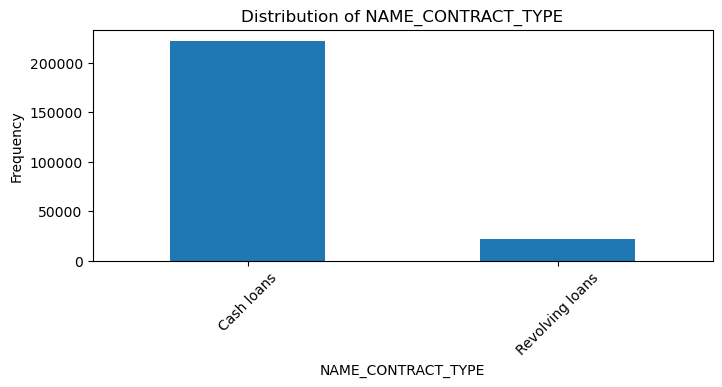

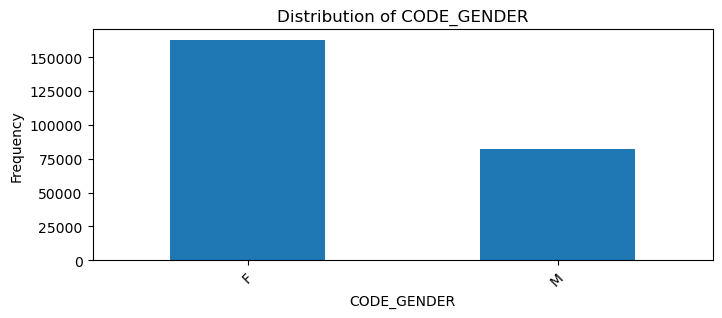

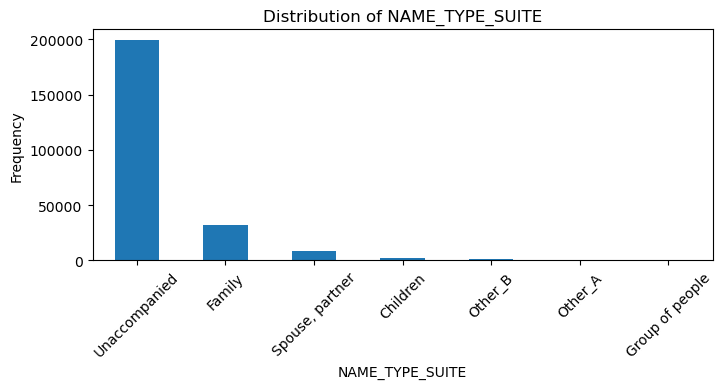

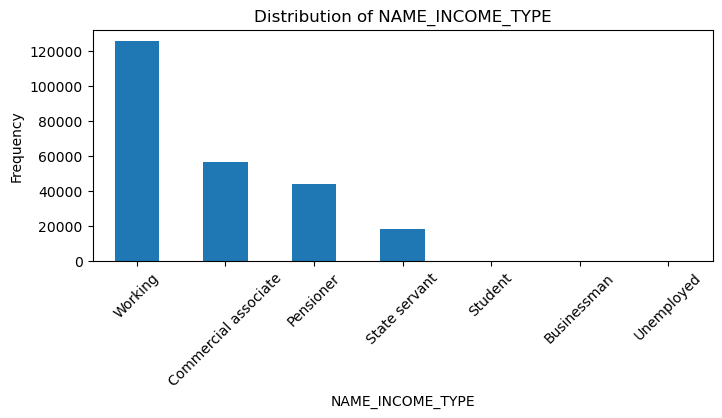

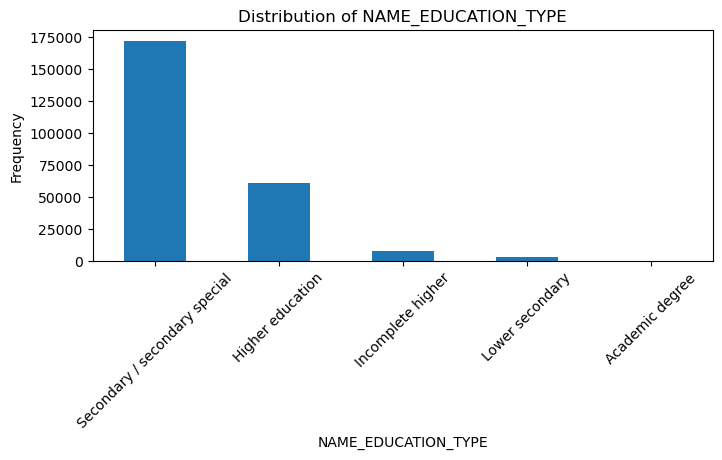

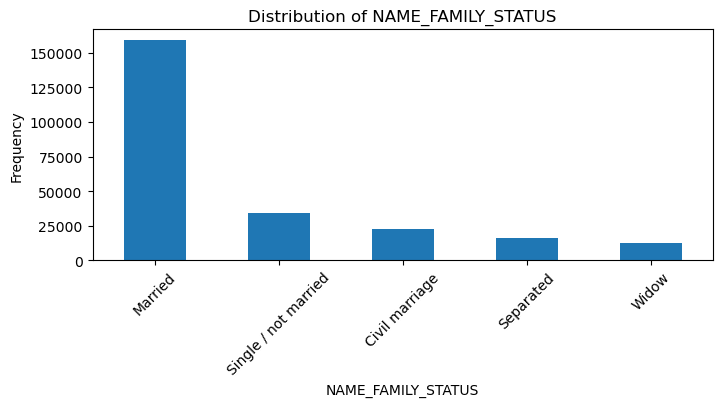

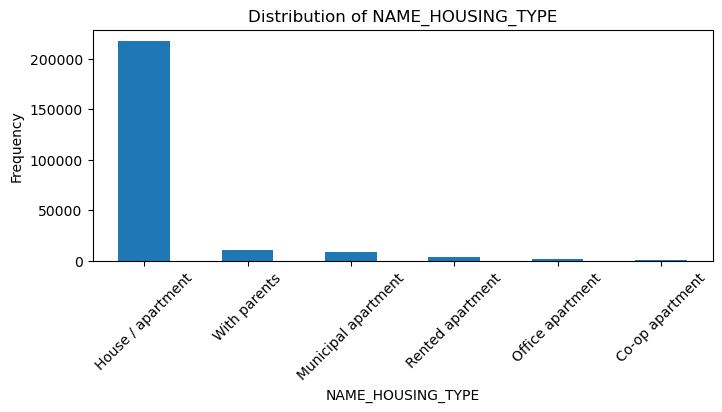

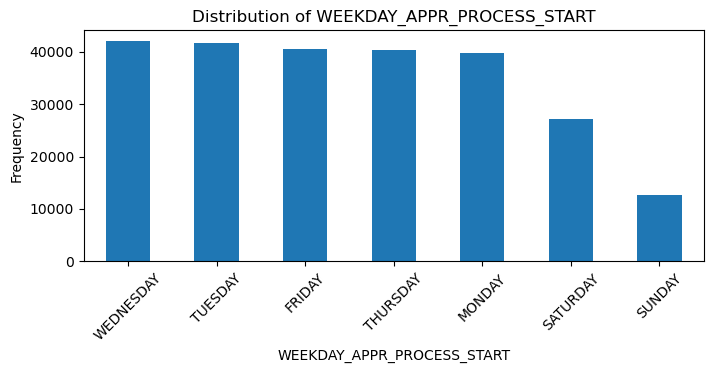

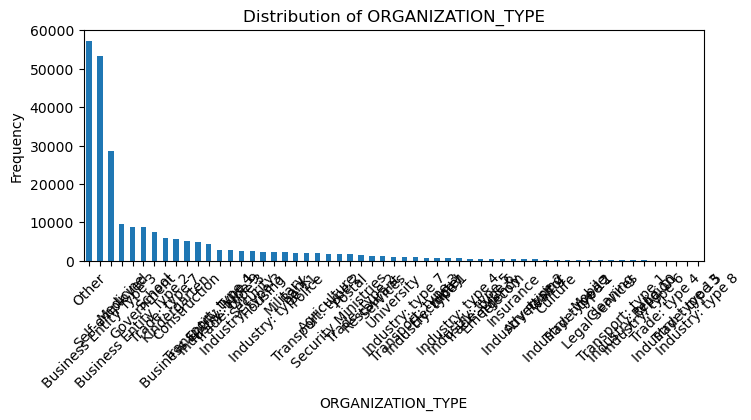

In [118]:
non_numeric_df = df_application_clean2.select_dtypes(exclude='number')
plot_categorical_frequencies(non_numeric_df)

In [119]:
#One hot encoding
non_numeric_columns = df_application_clean2.select_dtypes(exclude='number').columns
encoded_application_clean = pd.get_dummies(df_application_clean2, columns=non_numeric_columns)

In [120]:
encoded_application_clean.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade:

### C.Numerical Variables

In [121]:
numeric_columns= df_application_clean2.select_dtypes(include='number').columns
numeric_columns = numeric_columns.drop(['SK_ID_CURR','TARGET'])
numeric_columns = numeric_columns.drop(flag_columns)
numerical_summary = encoded_application_clean[numeric_columns].describe()
display(numerical_summary)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,244276.000000,2.442760e+05,2.442760e+05,244276.000000,2.442760e+05,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.00000,244276.000000
mean,0.424458,1.718670e+05,6.084740e+05,27205.595192,5.466429e+05,0.020747,-16134.893162,63619.595171,-4988.700961,-3051.456254,2.167348,2.054729,2.034850,12.104411,0.518439,0.510768,1.434852,0.144279,1.418068,0.100210,-996.763849,0.006382,0.006890,0.034477,0.276138,0.26407,1.901464
std,0.726917,2.574339e+05,4.044119e+05,14323.249293,3.710326e+05,0.013676,4297.238042,141215.000092,3519.683696,1489.535558,0.911461,0.502249,0.496762,3.241899,0.189122,0.194842,2.422940,0.447955,2.401941,0.362741,833.395377,0.083840,0.110143,0.204139,0.939155,0.60948,1.859787
min,0.000000,2.610000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25201.000000,-17912.000000,-24672.000000,-7197.000000,1.000000,1.000000,1.000000,0.000000,0.000001,0.000527,0.000000,0.000000,0.000000,0.000000,-4185.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,1.125000e+05,2.750400e+05,16713.000000,2.385000e+05,0.010006,-19724.000000,-2884.000000,-7482.000000,-4321.000000,2.000000,2.000000,2.000000,10.000000,0.400904,0.370650,0.000000,0.000000,0.000000,0.000000,-1611.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,1.575000e+05,5.212800e+05,25060.500000,4.500000e+05,0.018850,-15832.000000,-1281.000000,-4518.000000,-3336.000000,2.000000,2.000000,2.000000,12.000000,0.569991,0.535276,0.000000,0.000000,0.000000,0.000000,-812.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,1.000000,2.025000e+05,8.140410e+05,34780.500000,6.885000e+05,0.028663,-12602.000000,-307.000000,-2004.000000,-1818.000000,3.000000,2.000000,2.000000,14.000000,0.665158,0.669057,2.000000,0.000000,2.000000,0.000000,-293.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7676.000000,365243.000000,0.000000,0.000000,20.000000,3.000000,3.000000,23.000000,0.855000,0.896010,348.000000,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,8.00000,23.000000


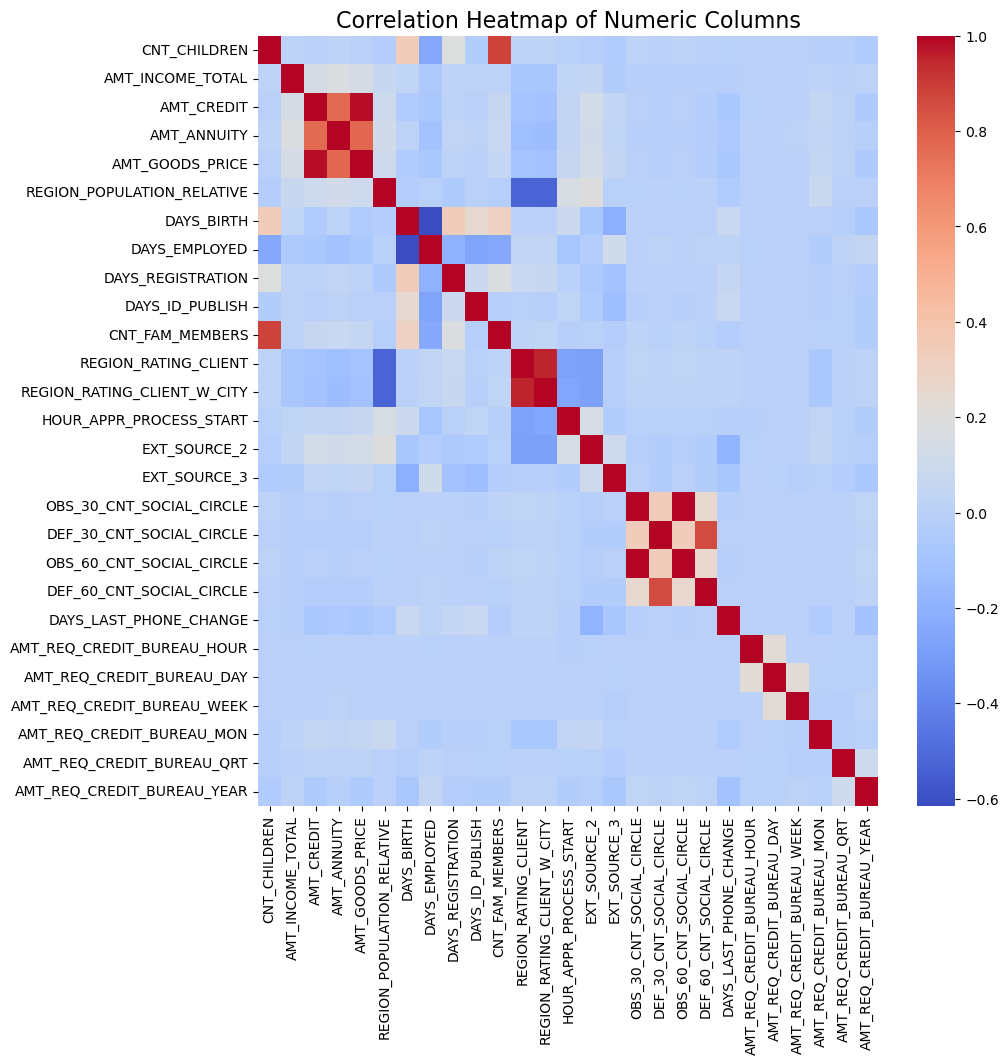

In [122]:
#check correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for numeric columns
correlation_matrix = df_application_clean2[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 10)) 
sns.heatmap(correlation_matrix, fmt=".2f", cmap="coolwarm", cbar=True)

# Add title
plt.title('Correlation Heatmap of Numeric Columns', fontsize=16)
plt.show()

In [123]:
#Top 10 correlation
# Compute the correlation matrix for numeric columns
correlation_matrix = df_application_clean2[numeric_columns].corr()

# Flatten the correlation matrix and exclude self-correlations
correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)]

# Sort by absolute value and get the top 10 correlations
top_10_correlations = correlation_pairs.abs().sort_values(ascending=False).head(10)

# Print the top 10 correlations with their feature pairs
print("Top 10 Correlations:")
for (feature1, feature2), correlation in top_10_correlations.items():
    print(f"{feature1} and {feature2}: {correlation:.2f}")

Top 10 Correlations:
OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE: 1.00
OBS_60_CNT_SOCIAL_CIRCLE and OBS_30_CNT_SOCIAL_CIRCLE: 1.00
AMT_GOODS_PRICE and AMT_CREDIT: 0.99
AMT_CREDIT and AMT_GOODS_PRICE: 0.99
REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT: 0.95
REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY: 0.95
CNT_FAM_MEMBERS and CNT_CHILDREN: 0.88
CNT_CHILDREN and CNT_FAM_MEMBERS: 0.88
DEF_30_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE: 0.86
DEF_60_CNT_SOCIAL_CIRCLE and DEF_30_CNT_SOCIAL_CIRCLE: 0.86


In [124]:
# standardize 
from sklearn.preprocessing import StandardScaler
encoded_application_clean_std = encoded_application_clean.copy()
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_application_clean[numeric_columns])


## **2.0** Feature & Model Selection

### PCA


### After Standardization ###
Total Variance: 27.0001
Skewness:
CNT_CHILDREN                     1.924701
AMT_INCOME_TOTAL               383.168157
AMT_CREDIT                       1.199433
AMT_ANNUITY                      1.518657
AMT_GOODS_PRICE                  1.308801
REGION_POPULATION_RELATIVE       1.487751
DAYS_BIRTH                      -0.111220
DAYS_EMPLOYED                    1.667117
DAYS_REGISTRATION               -0.584094
DAYS_ID_PUBLISH                  0.390190
CNT_FAM_MEMBERS                  0.973577
REGION_RATING_CLIENT             0.103782
REGION_RATING_CLIENT_W_CITY      0.073481
HOUR_APPR_PROCESS_START         -0.018132
EXT_SOURCE_2                    -0.822602
EXT_SOURCE_3                    -0.409233
OBS_30_CNT_SOCIAL_CIRCLE        14.228884
DEF_30_CNT_SOCIAL_CIRCLE         5.479254
OBS_60_CNT_SOCIAL_CIRCLE        14.138075
DEF_60_CNT_SOCIAL_CIRCLE         5.479829
DAYS_LAST_PHONE_CHANGE          -0.642264
AMT_REQ_CREDIT_BUREAU_HOUR      14.643642
AMT_REQ_CRE

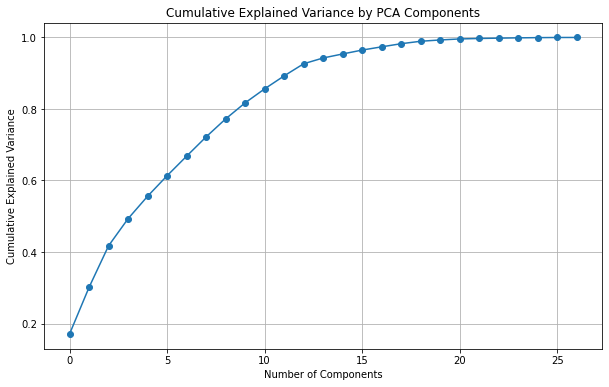

Optimal number of PCA components to retain 95% variance: 15


In [28]:
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Calculate Statistics Before and After Standardization
def calculate_statistics(data, label):
    variance = data.var().sum()
    skewness = data.apply(lambda x: skew(x))
    kurtosis_values = data.apply(lambda x: kurtosis(x))
    print(f"\n### {label} ###")
    print(f"Total Variance: {variance:.4f}")
    print(f"Skewness:\n{skewness}")
    print(f"Kurtosis:\n{kurtosis_values}")
    return variance, skewness, kurtosis_values

# Calculate statistics before standardization
variance_before, skewness_before, kurtosis_before = calculate_statistics(
    pd.DataFrame(X_scaled, columns=numeric_columns), "After Standardization"
)

# Step 2: Yeo-Johnson Transformation for Handling Skewness and Kurtosis
transformer = PowerTransformer(method='yeo-johnson', standardize=False)
X_transformed = transformer.fit_transform(X_scaled)
X_transformed_df = pd.DataFrame(X_transformed, columns=numeric_columns)

# Calculate statistics after Yeo-Johnson transformation
variance_after_transform, skewness_after_transform, kurtosis_after_transform = calculate_statistics(
    X_transformed_df, "After Yeo-Johnson Transformation"
)

# Step 3: PCA Analysis
pca = PCA()
pca_transformed = pca.fit_transform(X_transformed)

# Plot cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid()
plt.show()

# Determine the optimal number of components (95% variance)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of PCA components to retain 95% variance: {optimal_components}")

# Step 4: Apply PCA with Optimal Number of Components
pca_optimal = PCA(n_components=optimal_components)
X_pca_optimal = pca_optimal.fit_transform(X_transformed)



In [29]:
#Final Dataset- ready for feature selection
encoded_application_clean_std.head(5)

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade:

### Feature Selection

### Rondom Forest Feature

In [30]:
df = encoded_application_clean  # make a duplicate just in case

# Separate features and target variable
X = df.drop(columns=['TARGET'])  # Features 
y = df['TARGET']                 # Target


In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import randint

rf = RandomForestClassifier(random_state=42)

In [34]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

                   Feature  Importance
30            EXT_SOURCE_3    0.070888
29            EXT_SOURCE_2    0.064699
9               DAYS_BIRTH    0.046214
12         DAYS_ID_PUBLISH    0.045235
11       DAYS_REGISTRATION    0.045174
0               SK_ID_CURR    0.043951
6              AMT_ANNUITY    0.042334
35  DAYS_LAST_PHONE_CHANGE    0.041061
10           DAYS_EMPLOYED    0.040061
5               AMT_CREDIT    0.038841


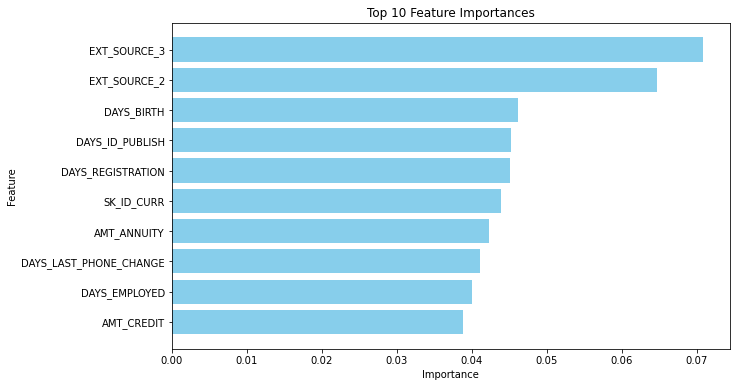

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feature_importances = rf.feature_importances_

# Create a DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order and get the top 10 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print the top 10 features
print(top_features)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Lasso

In [29]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [30]:
df = encoded_application_clean  # make a duplicate just in case

# Separate features and target variable
X = df.drop(columns=['TARGET'])  # Features
y = df['TARGET']                 # Target

# Standardize the features for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit Lasso Regression for feature selection
lasso = Lasso(alpha=0.001)  # higher alpha = stronger penalty
lasso.fit(X_train, y_train)

# Extract features with non-zero coefficients
selected_features = X.columns[lasso.coef_ != 0].tolist()

print("Selected Features by Lasso Regression:")
print(selected_features)
print("Number of selected features:", len(selected_features))

Selected Features by Lasso Regression:
['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATI

In [31]:
# Create a duplicate of the encoded DataFrame (optional, for safety)
df = encoded_application_clean.copy()

# Separate features and target variable
# Use PCA-transformed features instead of original features
X = X_pca_optimal  # PCA-transformed features from the previous cell
y = df['TARGET']   # Target variable

# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Lasso Regression for feature selection on PCA-transformed data
lasso = Lasso(alpha=0.001)  # Regularization strength (higher alpha = stronger penalty)
lasso.fit(X_train, y_train)

# Extract indices of PCA components with non-zero coefficients
selected_pca_components = [i for i, coef in enumerate(lasso.coef_) if coef != 0]

print("Selected PCA Components by Lasso Regression:")
print(selected_pca_components)
print("Number of selected PCA components:", len(selected_pca_components))


Selected PCA Components by Lasso Regression:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Number of selected PCA components: 15


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Filter the training and testing sets to only include selected features
X_train_selected = X_train[:, lasso.coef_ != 0]
X_test_selected = X_test[:, lasso.coef_ != 0]

# Step 2: Train and evaluate Random Forest model using all features
rf_all_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all_features.fit(X_train, y_train)

y_pred_all = rf_all_features.predict(X_test)
y_pred_proba_all = rf_all_features.predict_proba(X_test)[:, 1]

# Evaluate model with all features
accuracy_all = accuracy_score(y_test, y_pred_all)
f1_all = f1_score(y_test, y_pred_all)
roc_auc_all = roc_auc_score(y_test, y_pred_proba_all)

print("Random Forest Performance with All Features:")
print(f"Accuracy: {accuracy_all:.4f}")
print(f"F1 Score: {f1_all:.4f}")
print(f"ROC AUC Score: {roc_auc_all:.4f}")

# Step 3: Train and evaluate Random Forest model using only Lasso-selected features
rf_selected_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected_features.fit(X_train_selected, y_train)

y_pred_selected = rf_selected_features.predict(X_test_selected)
y_pred_proba_selected = rf_selected_features.predict_proba(X_test_selected)[:, 1]

# Evaluate model with Lasso-selected features
accuracy_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)

print("\nRandom Forest Performance with Lasso-Selected Features:")
print(f"Accuracy: {accuracy_selected:.4f}")
print(f"F1 Score: {f1_selected:.4f}")
print(f"ROC AUC Score: {roc_auc_selected:.4f}")

Random Forest Performance with All Features:
Accuracy: 0.9219
F1 Score: 0.0005
ROC AUC Score: 0.6875

Random Forest Performance with Lasso-Selected Features:
Accuracy: 0.9219
F1 Score: 0.0005
ROC AUC Score: 0.6875


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Use PCA-transformed features instead of the original features
X = X_pca_optimal  # PCA-transformed features from the previous PCA implementation
y = df['TARGET']   # Target variable

# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Train and evaluate Random Forest model using all PCA-transformed features
rf_all_features = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_all_features.fit(X_train, y_train)

# Make predictions and calculate probabilities
y_pred_all = rf_all_features.predict(X_test)
y_pred_proba_all = rf_all_features.predict_proba(X_test)[:, 1]

# Evaluate model with all PCA components
accuracy_all = accuracy_score(y_test, y_pred_all)
f1_all = f1_score(y_test, y_pred_all)
roc_auc_all = roc_auc_score(y_test, y_pred_proba_all)

print("Random Forest Performance with All PCA Components:")
print(f"Accuracy: {accuracy_all:.4f}")
print(f"F1 Score: {f1_all:.4f}")
print(f"ROC AUC Score: {roc_auc_all:.4f}")

# Step 2: Train and evaluate Random Forest model using Lasso-selected PCA components
# Filter the training and testing sets to include only Lasso-selected components
X_train_selected = X_train[:, selected_pca_components]
X_test_selected = X_test[:, selected_pca_components]

rf_selected_features = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_selected_features.fit(X_train_selected, y_train)

# Make predictions and calculate probabilities
y_pred_selected = rf_selected_features.predict(X_test_selected)
y_pred_proba_selected = rf_selected_features.predict_proba(X_test_selected)[:, 1]

# Evaluate model with Lasso-selected PCA components
accuracy_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)

print("\nRandom Forest Performance with Lasso-Selected PCA Components:")
print(f"Accuracy: {accuracy_selected:.4f}")
print(f"F1 Score: {f1_selected:.4f}")
print(f"ROC AUC Score: {roc_auc_selected:.4f}")


Random Forest Performance with All PCA Components:
Accuracy: 0.9219
F1 Score: 0.0016
ROC AUC Score: 0.6915

Random Forest Performance with Lasso-Selected PCA Components:
Accuracy: 0.9219
F1 Score: 0.0016
ROC AUC Score: 0.6915


### Christina's Logistic Regression

#### We're going to experiment with default L1 regularization first

Logistic Regression with L1 Regularization Performance:
Accuracy: 0.9217
F1 Score: 0.0175
ROC AUC Score: 0.7445

Confusion Matrix:
[[44996    44]
 [ 3782    34]]


/Users/christinajiang/Documents/GitHub/Credit-Risk-Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


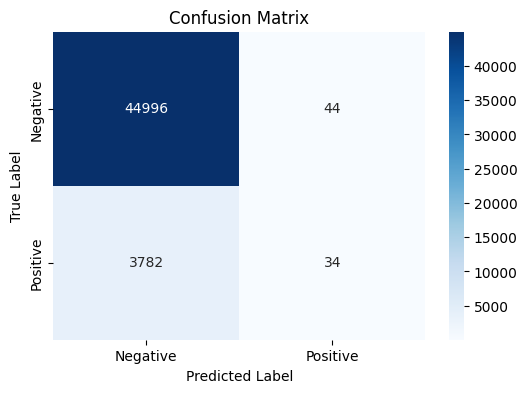


Selected Features by L1 Regularization:
Index(['SK_ID_CURR', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4',
       'ORGANIZATION_TYPE_Trade: type 5', 'ORGANIZATION_TYPE_Trade: type 6',
       'ORGANIZATION_TYPE_Trade: type 7',
       'ORGANIZATION_TYPE_Transport: type 1',
       'ORGANIZATION_TYPE_Transport: type 2',
       'ORGANIZATION_TYPE_Transport: type 3',
       'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University'],
      dtype='object', length=155)
Number of Selected Features: 155


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

df = encoded_application_clean.copy()

X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression with L1 Regularization
log_reg_l1 = LogisticRegression(
    penalty='l1',           # L1 regularization
    solver='saga',          # Saga solver supports L1 regularization
    max_iter=2000,          # Ensure sufficient iterations for convergence
    tol=1e-4,               # Convergence tolerance
    C=1.0,                  # Regularization strength (smaller values increase regularization)
    random_state=42
)

# Fit the model
log_reg_l1.fit(X_train, y_train)

# Evaluate the model
y_pred = log_reg_l1.predict(X_test)
y_pred_proba = log_reg_l1.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


print("Logistic Regression with L1 Regularization Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


selected_features = X.columns[log_reg_l1.coef_.flatten() != 0]
print("\nSelected Features by L1 Regularization:")
print(selected_features)
print(f"Number of Selected Features: {len(selected_features)}")


#### Although the accuracy is very high, but it is misleading as we can see from the confusion matrix that the true positive is extremely low

#### Therefore, I'll try another threshold


Adjusted Threshold Performance:
Accuracy: 0.9149
F1 Score: 0.1573
ROC AUC Score: 0.7445
Confusion Matrix (Adjusted Threshold):
[[44311   729]
 [ 3428   388]]


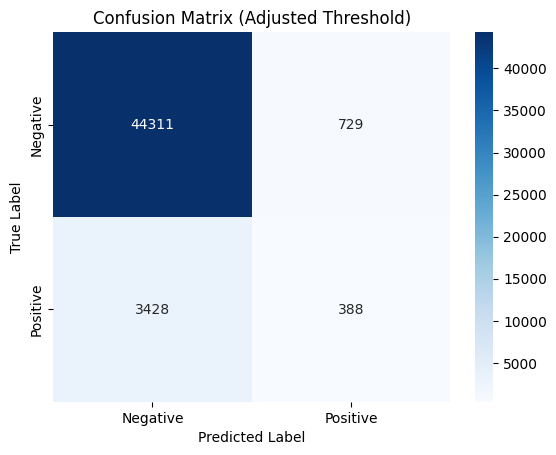

In [36]:
# Adjust threshold
threshold = 0.3  # Experiment with different thresholds
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Recompute metrics
accuracy_adj = accuracy_score(y_test, y_pred_adjusted)
f1_adj = f1_score(y_test, y_pred_adjusted)
roc_auc_adj = roc_auc_score(y_test, y_pred_proba)
conf_matrix_adj = confusion_matrix(y_test, y_pred_adjusted)

print("\nAdjusted Threshold Performance:")
print(f"Accuracy: {accuracy_adj:.4f}")
print(f"F1 Score: {f1_adj:.4f}")
print(f"ROC AUC Score: {roc_auc_adj:.4f}")
print("Confusion Matrix (Adjusted Threshold):")
print(conf_matrix_adj)

# Plot confusion matrix
sns.heatmap(conf_matrix_adj, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.show()


#### With a new threshold of 0,3, the result is incrementally better, but no where close to ideal
#### We need to try oversampling the true target data

In [38]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Re-train the logistic regression model
log_reg_l1.fit(X_resampled, y_resampled)
y_pred_resampled = log_reg_l1.predict(X_test)
y_pred_proba_resampled = log_reg_l1.predict_proba(X_test)[:, 1]

# Evaluate
conf_matrix_resampled = confusion_matrix(y_test, y_pred_resampled)
print("\nConfusion Matrix (After Resampling):")
print(conf_matrix_resampled)


Confusion Matrix (After Resampling):
[[31640 13400]
 [ 1352  2464]]


/Users/christinajiang/Documents/GitHub/Credit-Risk-Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### The result is more desirable, and now we can combine both resampling and a new threshold


Performance (Default Threshold):
Accuracy: 0.6922
F1 Score: 0.2531
ROC AUC Score: 0.7428
Confusion Matrix:
[[31270 13770]
 [ 1268  2548]]


/Users/christinajiang/Documents/GitHub/Credit-Risk-Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


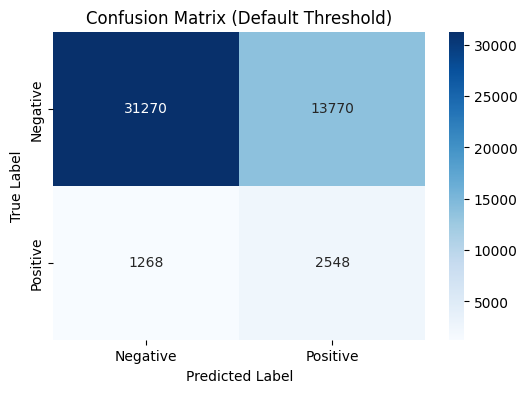


Performance (Adjusted Threshold):
Accuracy: 0.3928
F1 Score: 0.1892
ROC AUC Score: 0.7428
Confusion Matrix:
[[15733 29307]
 [  356  3460]]


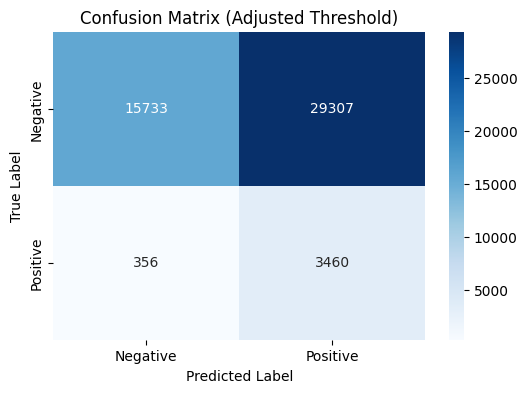

In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

df = encoded_application_clean.copy()
X = df.drop(columns=['TARGET'])
y = df['TARGET']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

log_reg_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=2000, tol=1e-4, C=1.0, random_state=42)
log_reg_l1.fit(X_resampled, y_resampled)

y_pred_proba = log_reg_l1.predict_proba(X_test)[:, 1]
y_pred_default = (y_pred_proba >= 0.5).astype(int)

threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

def evaluate_model(y_true, y_pred, y_proba, threshold_label):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    print(f"\nPerformance ({threshold_label} Threshold):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({threshold_label} Threshold)')
    plt.show()

evaluate_model(y_test, y_pred_default, y_pred_proba, "Default")
evaluate_model(y_test, y_pred_adjusted, y_pred_proba, "Adjusted")


#### Looks like the threshold of 0.3 doesn't hold anymore, we need to find the right threshold

Best Threshold based on F1 Score: 0.14438634037428819
Best Threshold based on Youden's Index (ROC Curve): 0.07965841298652741


ValueError: x and y must have same first dimension, but have shapes (48856,) and (48857,)

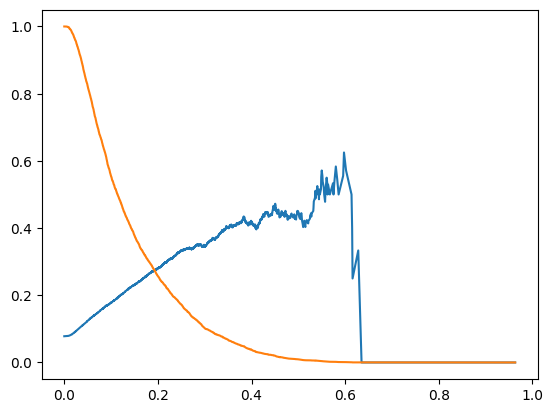

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
import numpy as np
import matplotlib.pyplot as plt

df = encoded_application_clean.copy()

X = df.drop(columns=['TARGET'])
y = df['TARGET']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression with L1 Regularization
log_reg_l1 = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    max_iter=5000,  # Increased max_iter
    tol=1e-4, 
    C=1.0, 
    random_state=42
)


log_reg_l1.fit(X_train, y_train)


y_pred_proba = log_reg_l1.predict_proba(X_test)[:, 1]

# Ensure that y_test and y_pred_proba have the same length
assert len(y_test) == len(y_pred_proba), f"Length mismatch: y_test({len(y_test)}) vs. y_pred_proba({len(y_pred_proba)})"

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Fix: Prevent division by zero when calculating F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

best_threshold_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_threshold_idx]

fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
youden_index = tpr - fpr
best_threshold_roc = thresholds_roc[np.argmax(youden_index)]


print(f"Best Threshold based on F1 Score: {best_threshold_f1}")
print(f"Best Threshold based on Youden's Index (ROC Curve): {best_threshold_roc}")


plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall, F1 Score vs Threshold")
plt.show()


plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


best_threshold = best_threshold_f1 

# Adjust predictions based on best threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Evaluate the model with adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [ ]:
print(f"\nPerformance with Adjusted Threshold ({best_threshold:.4f}):")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.show()


### Yunjing's Candidate Method - **XGBOOST**

In [125]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#### 0.create data for training and testing

In [126]:
df = encoded_application_clean.copy()  # make a duplicate just in case

# Separate features and target variable
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])  # Features
y = df['TARGET']                               # Target

# Identify flag variables (binary 0/1) and non-flag (continuous) variables
flag_columns = X.columns[(X.nunique() == 2) & X.isin([0, 1]).all()]  # Binary 0/1 columns
non_flag_columns = X.columns.difference(flag_columns)               # All other columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a ColumnTransformer to scale only non-flag columns
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), non_flag_columns)  # Apply scaler to non-flag columns
    ],
    remainder='passthrough'  # Keep flag columns unchanged
)

# Fit the transformer on training data and transform both training and test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

#### function for confusion matrix

In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_confusion_matrix(y_true, y_pred, display_labels=None):

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Extract TN, FP, FN, TP from the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()
    
    # Calculate rates
    TP_rate = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity or Recall
    FP_rate = FP / (FP + TN) if (FP + TN) > 0 else 0  # Fall-out
    FN_rate = FN / (TP + FN) if (TP + FN) > 0 else 0  # Miss rate
    TN_rate = TN / (FP + TN) if (FP + TN) > 0 else 0  # Specificity

    # Print the rates
    print(f"True Positive Rate (Recall): {TP_rate:.2f}")
    print(f"False Positive Rate: {FP_rate:.2f}")
    print(f"False Negative Rate: {FN_rate:.2f}")
    print(f"True Negative Rate (Specificity): {TN_rate:.2f}")
    
    # Visualize the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


#### 1.Initial XGB Classifier
##### Create an initial simple XGB model to get a view of the preliminary result

In [128]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',       # Evaluation metric
    use_label_encoder=False,     # Avoid label encoding warnings
    random_state=42
)

# Train the model
xgb_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_prob = xgb_classifier.predict_proba(X_test_scaled)[:, 1]  # Probabilities for positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

/Users/yunjingzhan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.921340
ROC AUC: 0.743942


True Positive Rate (Recall): 0.03
False Positive Rate: 0.00
False Negative Rate: 0.97
True Negative Rate (Specificity): 1.00


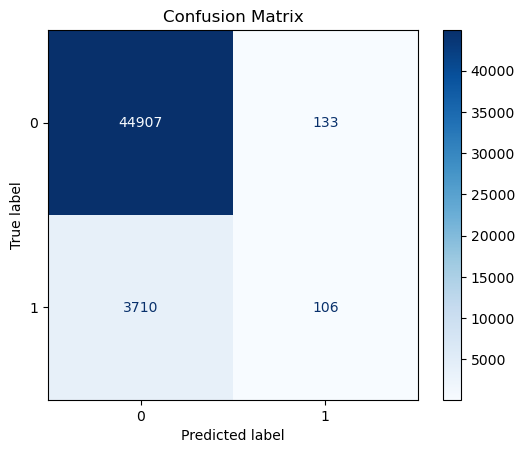

In [131]:
evaluate_confusion_matrix(y_test, y_pred, display_labels=xgb_classifier.classes_)

##### Based on the testing metrics above, although the accuracy appears very high, this is primarily due to the imbalanced nature of the dataset. Our goal is to achieve more accurate predictions for customers who may default. Therefore, we need to prioritize metrics such as the True Positive Rate and AUC over accuracy. In this initial model, the True Positive Rate is significantly low (only 3%), indicating the need to address the data imbalance and further tune the model for improved performance.

#### 2. Address the **imbalanced data** issue by adding weight
#####  As we can see in EDA, this data only has ~10% target = 1 which indicates the data is imbalanced. The scale_pos_weight parameter adjusts the weight of positive class instances, making the model focus more on the minority class.

In [132]:
neg_class = y_train.value_counts()[0]
pos_class = y_train.value_counts()[1]
scale_pos_weight = neg_class / pos_class
scale_pos_weight

11.843059936908517

#### 3.reduce feature

##### As we can see from the EDA, there are many variable in this data has high correlation and also having too many features increases the risk of overfitting, especially if some features are irrelevant or noisy. Moreover, Reducing features decreases the number of splits the algorithm has to evaluate, speeding up training. Therefore, We applied a simple XGB Classfier and select top 50 features based on importance.

In [133]:
# Fit a preliminary model
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train_scaled, y_train)

# Select top 50 features based on importance
feature_importances = xgb_model.feature_importances_

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

important_features = X_train_scaled.columns[feature_importances.argsort()[-50:]]
X_train_reduced = X_train_scaled[important_features]
X_test_reduced = X_test_scaled[important_features]


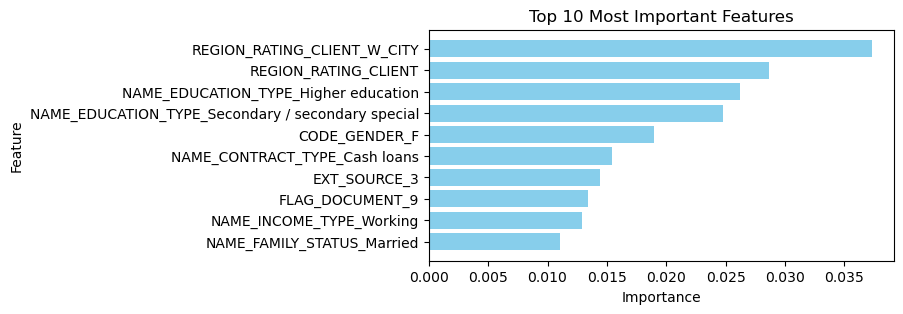

In [134]:
import matplotlib.pyplot as plt
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 3))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##### The top 10 features align well with the context of credit risk classification. For example, the rating of the region where the borrower resides, the borrower’s education level, and their employment status are all highly relevant factors that could influence a client’s ability to repay the loan and the risk of default.

#### 4. XGBOOST with weight adjustment & reduced features

In [135]:
xgb_classifier2 = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight, # adjust weight
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',       # Evaluation metric
    use_label_encoder=False,     # Avoid label encoding warnings
    random_state=42
)

# Train the model
xgb_classifier2.fit(X_train_reduced, y_train)

# Make predictions
y_pred = xgb_classifier2.predict(X_test_reduced)
y_pred_prob = xgb_classifier2.predict_proba(X_test_reduced)[:, 1]  # Probabilities for positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

/Users/yunjingzhan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.735120
ROC AUC: 0.734212


True Positive Rate (Recall): 0.60
False Positive Rate: 0.25
False Negative Rate: 0.40
True Negative Rate (Specificity): 0.75


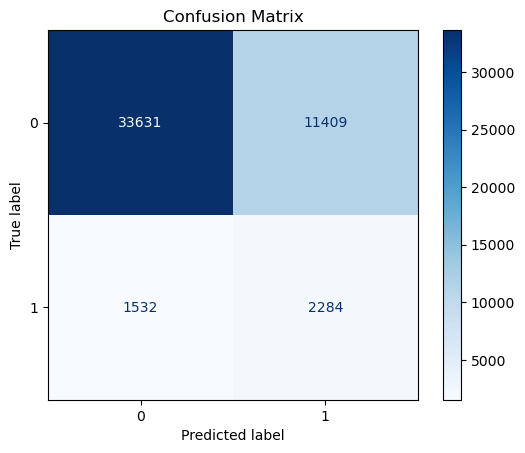

In [136]:
evaluate_confusion_matrix(y_test, y_pred, display_labels=xgb_classifier2.classes_)

##### As we can see from the confusion martix from the second XGBOOST Model. The ture positive rate sigifincantly improved from 3% to 60%. This is due to the scale_pos_weight parameter adjustment. The reduced feature also helpped in eliminating the impact of irrelavant and noisy features. However, the AUC slightly decreased which means we need to perform further hyperparameter tuning.

#### 5.Hyperparameter Tuning

In [137]:
# Randomly sample 10% of the data while preserving class distribution
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_reduced, y_train, test_size=0.9, stratify=y_train, random_state=42
)

print(subset_X_train.shape)
print(subset_y_train.shape)

(19542, 50)
(19542,)


In [94]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [scale_pos_weight * 0.5, scale_pos_weight, scale_pos_weight * 1.5]  # Range of weights
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=param_grid,
    n_iter=50,  # Test 50 combinations
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(subset_X_train, subset_y_train)

# Best parameters from random search
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 5.921529968454259, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}


#### 6. Recommended candidate model -XGBOOST 

In [138]:

# Use the best parameters to train a new model
xgb_best_model = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    gamma =0,
    colsample_bytree=0.8,
    scale_pos_weight=5.921529968454259,
    objective='binary:logistic',  # Ensure the same objective
    use_label_encoder=False,
    random_state=42
)

# Train the model on the full training set
xgb_best_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred = xgb_best_model.predict(X_test_reduced)
y_pred_prob = xgb_best_model.predict_proba(X_test_reduced)[:, 1]

# Evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

/Users/yunjingzhan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.861982
ROC AUC: 0.740984


True Positive Rate (Recall): 0.35
False Positive Rate: 0.09
False Negative Rate: 0.65
True Negative Rate (Specificity): 0.91


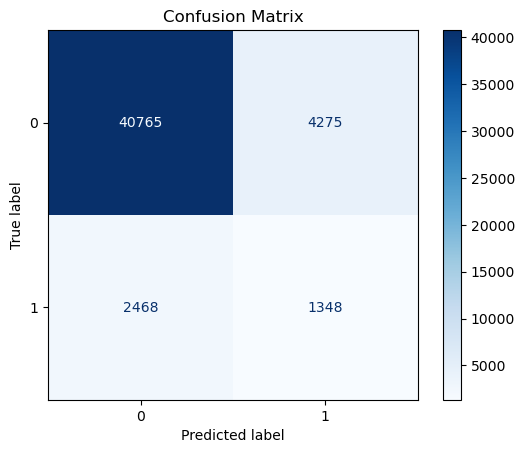

In [139]:
evaluate_confusion_matrix(y_test, y_pred, display_labels=xgb_best_model.classes_)

#### This model demonstrates relatively better performance in terms of accuracy, AUC, and True Positive Rate & True Negative Rate. Compared to the previous model, the True Positive Rate has decreased, but the True Negative Rate has increased, along with improvements in both accuracy and AUC. Although the previous model showed a significantly higher True Positive Rate, it compromised heavily on the False Positive Rate, which adversely impacted the overall accuracy. Balancing these metrics requires a trade-off, and this model is recommended due to its more balanced performance.

### previous_application.csv - ignore for now

In [50]:
#df_previous_application = pd.read_csv('previous_application.csv')
#df_previous_application.head()

In [51]:
#df_previous_application[df_previous_application['SK_ID_CURR']==100003]